In [1]:
# https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html
import os
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import random
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from tqdm.notebook import tqdm

import torch
import torch.nn as nn

In [12]:
# from google.colab import drive
# drive.mount('/content/drive')
# os.chdir("drive/MyDrive/name_recognition")

In [15]:
def find_files(path):
    return glob.glob(path)

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def read_lines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

def category_from_output(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

def random_choice(l):
    return l[random.randint(0, len(l) - 1)]

def random_training_example():
    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)],
                                   dtype=torch.long)
    line_tensor = name_to_tensor(line)
    return category, line, category_tensor, line_tensor
    
def letter_to_index(letter):
    return all_letters.find(letter)

def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

def name_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letter_to_index(letter)] = 1
    tensor = tensor.type(torch.long)
    return tensor

def tensor_to_name(tensor):
    name = ""
    for i in tensor:
        bool_tensor = i == 1
        index = bool_tensor.nonzero(as_tuple=True)[1][0]
        letter = all_letters[index]
        name += letter
    return name

In [29]:
# Build the category_lines dictionary, a list of names per language
"""
category_lines = {}
all_categories = []

for filename in find_files('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

# Create x and y data
data = np.empty((0, 2))
for key, values in category_lines.items():
    keys = [key] * len(values)
    to_add = np.column_stack((keys, values))
    data = np.vstack((data, to_add))
"""

for file_name in os.listdir("data/names"):
    with open("data/names/" + file_name) as file:
        names = file.read()
    
    names = names.split("\n")
    names = [i for i in names if i != ""]
    print(names)

"""
# Create a train and validation set
np.random.shuffle(data)
data_train = data[:int(data.shape[0]*0.8)]
data_val = data[int(data.shape[0]*0.8):]

x_train = data_train[:, 1]
y_train = data_train[:, 0]
x_val = data_val[:, 1]
y_val = data_val[:, 0]

# Encode the letters of the names as letters and factorise the countries
x_train = np.array([name_to_tensor(i) for i in x_train])
x_val = np.array([name_to_tensor(i) for i in x_val])

countries_to_factor_map = {j: i for i, j in enumerate(np.unique(y_train))}
factor_to_countries_map = {j: i for i, j in countries_to_factor_map.items()}

y_train = torch.tensor([countries_to_factor_map[i] for i in y_train]).type(torch.long)
y_val = torch.tensor([countries_to_factor_map[i] for i in y_val]).type(torch.long)
"""

['Abl', 'Adsit', 'Ajdrna', 'Alt', 'Antonowitsch', 'Antonowitz', 'Bacon', 'Ballalatak', 'Ballaltick', 'Bartonova', 'Bastl', 'Baroch', 'Benesch', 'Betlach', 'Biganska', 'Bilek', 'Blahut', 'Blazek', 'Blazek', 'Blazejovsky', 'Blecha', 'Bleskan', 'Blober', 'Bock', 'Bohac', 'Bohunovsky', 'Bolcar', 'Borovka', 'Borovski', 'Borowski', 'Borovsky', 'Brabbery', 'Brezovjak', 'Brousil', 'Bruckner', 'Buchta', 'Cablikova', 'Camfrlova', 'Cap', 'Cerda', 'Cermak', 'Chermak', 'Cermak', 'Cernochova', 'Cernohous', 'Cerny', 'Cerney', 'Cerny', 'Cerv', 'Cervenka', 'Chalupka', 'Charlott', 'Chemlik', 'Chicken', 'Chilar', 'Chromy', 'Cihak', 'Clineburg', 'Klineberg', 'Cober', 'Colling', 'Cvacek', 'Czabal', 'Damell', 'Demall', 'Dehmel', 'Dana', 'Dejmal', 'Dempko', 'Demko', 'Dinko', 'Divoky', 'Dolejsi', 'Dolezal', 'Doljs', 'Dopita', 'Drassal', 'Driml', 'Duyava', 'Dvorak', 'Dziadik', 'Egr', 'Entler', 'Faltysek', 'Faltejsek', 'Fencl', 'Fenyo', 'Fillipova', 'Finfera', 'Finferovy', 'Finke', 'Fojtikova', 'Fremut', 'Fried

'\n# Create a train and validation set\nnp.random.shuffle(data)\ndata_train = data[:int(data.shape[0]*0.8)]\ndata_val = data[int(data.shape[0]*0.8):]\n\nx_train = data_train[:, 1]\ny_train = data_train[:, 0]\nx_val = data_val[:, 1]\ny_val = data_val[:, 0]\n\n# Encode the letters of the names as letters and factorise the countries\nx_train = np.array([name_to_tensor(i) for i in x_train])\nx_val = np.array([name_to_tensor(i) for i in x_val])\n\ncountries_to_factor_map = {j: i for i, j in enumerate(np.unique(y_train))}\nfactor_to_countries_map = {j: i for i, j in countries_to_factor_map.items()}\n\ny_train = torch.tensor([countries_to_factor_map[i] for i in y_train]).type(torch.long)\ny_val = torch.tensor([countries_to_factor_map[i] for i in y_val]).type(torch.long)\n'

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.dropout = nn.Dropout(0.5)
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        hidden = self.dropout(hidden)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

def train(category_tensor, line_tensor):
    hidden = rnn.init_hidden()
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

n_hidden = 2**10 # 1024
criterion = nn.NLLLoss()
learning_rate = 0.005
n_iters = x_train.shape[0]
print_every = 5000
plot_every = 1000

In [ ]:
rnn = RNN(n_letters, n_hidden, n_categories)

# Keep track of losses for plotting
current_loss = 0
all_losses = []

for epoch in range(1):
    for iter in tqdm(range(n_iters)):
        # Take an x and y sample
        x_sample = x_train[iter]

        y_sample = y_train[iter]
        y_sample = torch.Tensor([y_sample]).type(torch.long)

        # Train the model and save the loss
        output, loss = train(y_sample, x_sample)

        current_loss += loss
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0

        # Generate validation score

  0%|          | 0/16059 [00:00<?, ?it/s]

In [ ]:
rnn = RNN(n_letters, n_hidden, n_categories)
optimizer = torch.optim.SGD(rnn.parameters(), lr=0.001, momentum=0.9)
def train_one_epoch():
    train_loss = []
    for i in tqdm(range(x_train.shape[0])):
        # Take an x and y sample
        x_sample = x_train[i]
        y_sample = y_train[i]
        y_sample = torch.Tensor([y_sample]).type(torch.long)

        # Initialise hidden state and zero gradients
        hidden = rnn.init_hidden()
        optimizer.zero_grad()

        # Make a prediction for this batch / iteration
        for i in range(x_sample.size()[0]):
            output, hidden = rnn(x_sample[i], hidden)
        
        loss = criterion(output, y_sample)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Save the loss
        if i % 100 == 0:
            train_loss.append(loss)


train_one_epoch()

  0%|          | 0/16059 [00:00<?, ?it/s]

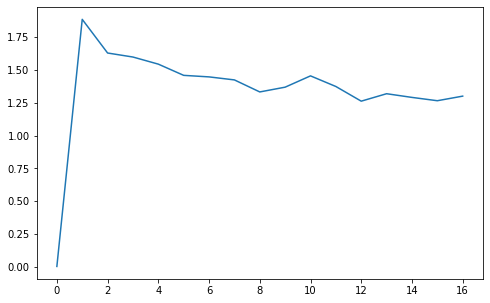

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(all_losses)
plt.show()

In [ ]:
def evaluate(line_tensor):
    hidden = rnn.init_hidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(name_to_tensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict("nash")


> nash
(-1.19) Greek
(-1.46) Irish
(-2.43) Korean
